In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline  

import numpy as np
import math
import sys
sys.path.append('../../')

from test_functions.test2 import boundary_func_1, boundary_func_3, g_func_1, g_func_3

from utilities.norms import l2_norm
from utilities.visualization import *
from utilities.accuracy import l2_norm_deviation
from utilities.instruments import cur_cord, input_values, regularization, noising

from matrices_functions.task_solvers import conj_solver, direct_solver
from matrices_functions.main_operator_matrix import only_speed

## Подготовка параметров системы

In [2]:
promt = 'Which test?\nPress 1: m = n = 1\nPress 3: m = n = 3\nPress: '
choice = int(input(promt))
m = n = choice
l = math.pi
T = 3 * math.pi/2;
M = input_values()
N = 2 * M + 10
h = l/(M-1)
print()
if_reg, tau = regularization(h)
N = math.ceil(T/tau + 1) + 1
tau = T/(N-1)
print(f'\nN = {N}')
print(f'h = {h}')
print(f'tau = {tau}')
print(tau/h)

Which test?
Press 1: m = n = 1
Press 3: m = n = 3
Press: 3
С какой задачей будете работать? 
Нажмите 0: M = 5
Нажмите 1: M = 10
Нажмите 2: M = 20
Нажмите 3: M = 50
Нажмите 4: M = 100
Нажмите 5: M = 200
Нажмите 6: M = 300
Нажмите 7: M = 600
Нажмите 8: Введите свое значение M
Введите значение 7

Какой вариант задачи будет решаться?
Нажмите 0: h=tau
Нажмите 1: h=2*tau
Введите значение 0

N = 901
h = 0.005244728970934546
tau = 0.005235987755982988
0.9983333333333333


## Матрица оператора левой части

In [3]:
# конструируем матрицу основного оператора 
# main_operator = only_speed(M, N, h, tau)
if if_reg == 0:
    filename = f'Saved_Arrays/M={M}.npy'
else:
    filename = f'h=2tau/M={M}.npy'
main_operator = np.load(filename)

## Аналитические расчеты 

In [4]:
# аналитически считаем g_vector - вектор-цель через формулу из статьи Ильина-Моисеева
g_star = np.zeros(M-1, float)
x_span = np.zeros(M-1, float)

for idx in range(len(g_star)):
    cur_x       = cur_cord(idx+1, h)
    x_span[idx] = cur_x
    if m == 1:
        g_star[idx] = g_func_1(cur_x)
    else:
        g_star[idx] = g_func_3(cur_x)

    
decision = noising()
if decision:
    if M <= 50:
        q = 6
    elif M <= 200:
        q = 1.5
    else:
        q = 0.5
    
    g_star_norm = 3*np.sqrt(np.pi/2)
    k = q * g_star_norm / (100 * np.sin(1000*x_span))
    noise = k*np.sin(1000*x_span)*g_star_norm
    g_star_noised = g_star + noise

Необходимо ли зашумить целевой вектор
Нажмите 0: нет
Нажмите 1: да
Введите значение 1


## Основные вычисления


In [5]:
# используем аналтически подсчитанные краевые условия для подсчета значений в узлах
u1_star = np.zeros(N-1, float)
u2_star = np.zeros(N-1, float)
t_span  = np.zeros(N-1, float)

zero_initial_pos   = np.zeros(M-1, float)
zero_initial_speed = np.zeros(M-1, float)

for i in range(N-1):
    cur_t      = cur_cord(i+1, tau)
    t_span[i]  = cur_t
    if m == 1:
        u1_star[i] = boundary_func_1(cur_t)
        u2_star[i] = boundary_func_1(cur_t)
    else:
        u1_star[i] = boundary_func_3(cur_t)
        u2_star[i] = boundary_func_3(cur_t)
        
# используем подсчитанные краевые значения для решения прямой задачи
g = direct_solver(zero_initial_pos, zero_initial_speed, u1_star, u2_star, M, N, h, tau)[1]

In [6]:
zero_left  = np.zeros(N-1, float)
zero_right = np.zeros(N-1, float)

# решаем СЛАУ CAA*C*v=g
v = np.linalg.solve(main_operator, g)

# решаем сопряженную задачу A*B*v=u
zero_speed = np.zeros(v.shape, float)
u_vect     = conj_solver(zero_speed, -v, zero_left, zero_right, M, N, h, tau)

# u1 = u_vect[0]
# u2 = u_vect[1]

if m == 1:
    u1 = -np.flip(u_vect[0])
    u2 = -np.flip(u_vect[1])
else:
    u1 = np.flip(u_vect[0]) * 3
    u2 = np.flip(u_vect[1]) * 3

# Для зашумленного вектора
if decision:
    v_noised = np.linalg.solve(main_operator, g_star_noised)
    u_vect_noised = conj_solver(zero_speed, v_noised, zero_left, zero_right, M, N, h, tau)
    if m == 1:
        u1_noised = np.flip(u_vect_noised[0])
        u2_noised = np.flip(u_vect_noised[1])
    else:
        u1_noised = -3 * np.flip(u_vect_noised[0])
        u2_noised = -3 * np.flip(u_vect_noised[1]) 

In [7]:
# Аналитически подсчитанное управление
u_star = np.zeros(2*len(u1), float)
u_star[:len(u1)] = u1_star
u_star[len(u1):] = u2_star

# Программно подсчитанное управление, следующее из корректных g* 
u = np.zeros(2*len(u1), float)
u[:len(u1)] = u1
u[len(u1):] = u2

# Программно подсчитанное управление, слудеющее из защумленных g*
if decision:
    u_noised = np.zeros(2*len(u1), float)
    u_noised[:len(u1)] = u1_noised
    u_noised[len(u1):] = u2_noised

In [8]:
# Восстановление целевого вектора по зашумленным данным
g_after_noising = direct_solver(zero_initial_pos, zero_initial_speed, u1_noised, u2_noised, M, N, h, tau)[1]

## Вычисление точности решения

In [9]:
print(f'M = {M}, N = {N}')
print(f'g deviation is {l2_norm_deviation(g, g_star, h)/l2_norm(g, h)}')
print(f'noised g deviation is {l2_norm_deviation(g_after_noising, g_star, h)/l2_norm(g_after_noising, h)}')
print()
print(f'u deviation is {l2_norm_deviation(u, u_star, tau)/l2_norm(u_star, tau)}')
if decision:
    print(f'noised u deviation is {l2_norm_deviation(u_noised, u_star, tau)/l2_norm(u_star, tau)}')

M = 600, N = 901
g deviation is 0.3963654042758599
noised g deviation is 0.4708521909024176

u deviation is 0.19113532495152616
noised u deviation is 0.6639080000320251


## Визуализация полученных данных

In [10]:
# draw_comparison(np.arange(0, T, tau), u1 , u1_star)
# draw_comparison(np.arange(0, T, tau), u2 , u2_star)
# draw_comparison(np.arange(0, l, h), g , g_star)

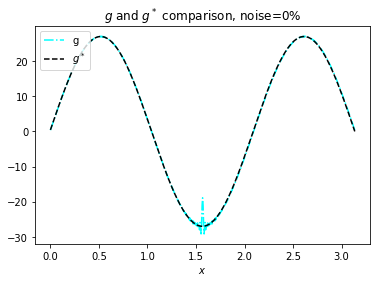

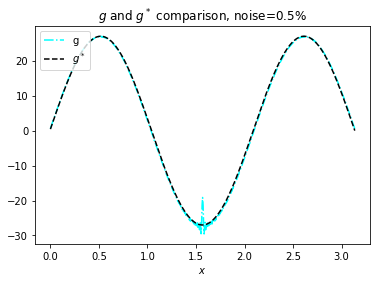

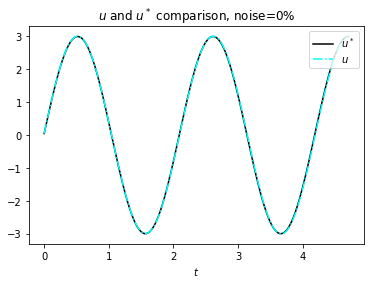

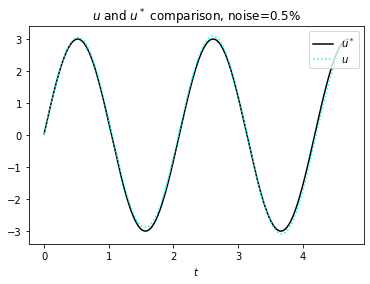

In [11]:
if m == 1:
    if M == 50:
        draw_g_comparison(np.arange(0, l, h  ), g, g_star, 0, '../../Pictures/test2/first_case/fig1')
        draw_g_comparison(np.arange(0, l, h  ), g_after_noising, g_star, q, '../../Pictures/test2/first_case/fig2')
        draw_u_comparison(np.arange(0, T-tau/2, tau), u1, u1_star, '../../Pictures/test2/first_case/fig3', 0, 
                          left=True, noised=False)
        draw_u_comparison(np.arange(0, T-tau/2, tau), u2_noised, u1_star, '../../Pictures/test2/first_case/fig4', q,
                          left=True, noised=True)
    elif M == 200:
        draw_g_comparison(np.arange(0, l, h  ), g, g_star, 0, '../../Pictures/test2/first_case/fig5')
        draw_g_comparison(np.arange(0, l, h  ), g_after_noising, g_star, q, '../../Pictures/test2/first_case/fig6')
        draw_u_comparison(np.arange(0, T, tau), u1, u1_star, '../../Pictures/test2/first_case/fig7', 0, 
                          left=True, noised=False)
        draw_u_comparison(np.arange(0, T, tau), u1_noised, u1_star, '../../Pictures/test2/first_case/fig8', q,
                          left=True, noised=True)
    elif M == 600:
        draw_g_comparison(np.arange(0, l, h  ), g, g_star, 0, '../../Pictures/test2/first_case/fig9')
        draw_g_comparison(np.arange(0, l, h  ), g_after_noising, g_star, q, '../../Pictures/test2/first_case/fig10')
        draw_u_comparison(np.arange(0, T-tau, tau), u1, u1_star, '../../Pictures/test2/first_case/fig11', 0, 
                          left=True, noised=False)
        draw_u_comparison(np.arange(0, T-tau, tau), u1_noised, u1_star, '../../Pictures/test2/first_case/fig12', q,
                          left=True, noised=True)
elif m == 3:
    if M == 50:
        draw_g_comparison(np.arange(0, l, h  ), g, g_star, 0, '../../Pictures/test2/second_case/fig1')
        draw_g_comparison(np.arange(0, l, h  ), g_after_noising, g_star, q, '../../Pictures/test2/second_case/fig2')
        draw_u_comparison(np.arange(0, T-tau/2, tau), u1, u1_star, '../../Pictures/test2/second_case/fig3', 0, 
                          left=True, noised=False)
        draw_u_comparison(np.arange(0, T-tau/2, tau), u2_noised, u1_star, '../../Pictures/test2/second_case/fig4', q,
                          left=True, noised=True)
    elif M == 200:
        draw_g_comparison(np.arange(0, l, h  ), g, g_star, 0, '../../Pictures/test2/second_case/fig5')
        draw_g_comparison(np.arange(0, l, h  ), g_after_noising, g_star, q, '../../Pictures/test2/second_case/fig6')
        draw_u_comparison(np.arange(0, T, tau), u1, u1_star, '../../Pictures/test2/second_case/fig7', 0, 
                          left=True, noised=False)
        draw_u_comparison(np.arange(0, T, tau), u1_noised, u1_star, '../../Pictures/test2/second_case/fig8', q,
                          left=True, noised=True)
    elif M == 600:
        draw_g_comparison(np.arange(0, l, h  ), g, g_star, 0, '../../Pictures/test2/second_case/fig9')
        draw_g_comparison(np.arange(0, l, h  ), g_after_noising, g_star, q, '../../Pictures/test2/second_case/fig10')
        draw_u_comparison(np.arange(0, T-tau, tau), u1, u1_star, '../../Pictures/test2/second_case/fig11', 0, 
                          left=True, noised=False)
        draw_u_comparison(np.arange(0, T-tau, tau), u1_noised, u1_star, '../../Pictures/test2/second_case/fig12', q,
                          left=True, noised=True)

In [12]:
print(f'tau={tau}   h={h}    tau/h={tau/h}')

tau=0.005235987755982988   h=0.005244728970934546    tau/h=0.9983333333333333
